# Calculate vertical actions for Kepler stars.

In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
from scipy.stats import gamma
import requests
from io import BytesIO
from actions import action

In [56]:
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

Download the KIC.

In [57]:
stlr = get_catalog("q1_q16_stellar")

Make cuts.

In [58]:
# Select G and K dwarfs.
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

# Lines to change for different stellar parameters.
var_names = ["koi_period", "koi_prad", "teff"]

period_rng = (50, 300)
radius_rng = (0.75, 2.5)
teff_rng = (4200, 6101)

In [59]:
kois = get_catalog("q1_q16_koi")

In [60]:
# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid", "teff"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
m &= np.isfinite(kois.koi_prad) & (radius_rng[0] <= kois.koi_prad) & (kois.koi_prad <= radius_rng[1])

kois = pd.DataFrame(kois[m])

print("Selected {0} KOIs after cuts".format(len(kois)))

Selected 154 KOIs after cuts


(91446, 99)


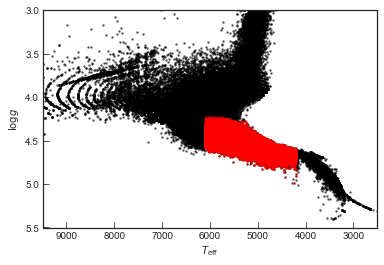

In [61]:
plt.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
plt.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.ylim(5.5, 3)
plt.ylabel("$\log g$");
plt.xlabel("$T_\mathrm{eff}$");
print(np.shape(stlr))

Load the Kepler-Gaia crossmatch and cut on relative parallax error > 10%.

In [62]:
dat = Table.read('kepler_dr2_4arcsec.fits', format='fits')
d = dat.to_pandas()
d["relative_parallax_err"] = d.parallax_error.values / d.parallax.values
m = d.relative_parallax_err.values < .1
df = d.iloc[m]

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less



215871
183279


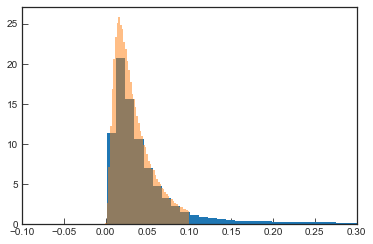

In [96]:
m = np.isfinite(d.relative_parallax_err) & \
    (-.1 < d.relative_parallax_err) & (d.relative_parallax_err < 1)
plt.hist(d.relative_parallax_err[m], 100, normed=True);
print(len(d.relative_parallax_err[m]))

m = np.isfinite(d.relative_parallax_err) & \
    (-.1 < d.relative_parallax_err) & (d.relative_parallax_err < .1)
plt.hist(d.relative_parallax_err[m], 100, normed=True, alpha=.5);
plt.xlim(-.1, .3)
print(len(d.relative_parallax_err[m]))

Then crossmatch the exopop catalogues with the Gaia-Kepler catalogue.

In [63]:
stlr_gaia = pd.merge(stlr, df, on="kepid", how="inner", suffixes=["_kepler", "_gaia"])
print(np.shape(stlr), np.shape(df), np.shape(stlr_gaia))

(91446, 99) (192038, 62) (89536, 160)


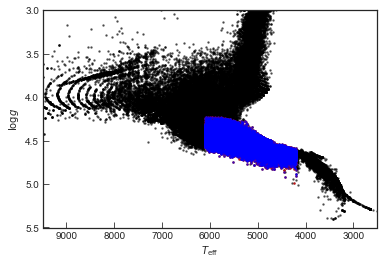

In [64]:
plt.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
plt.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
plt.plot(stlr_gaia.teff_kepler, stlr_gaia.logg_kepler, ".b", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.ylim(5.5, 3)
plt.ylabel("$\log g$");
plt.xlabel("$T_\mathrm{eff}$");

In [65]:
stlr_gaia.keys()

Index(['kepid', 'tm_designation_kepler', 'teff_kepler', 'teff_err1_kepler',
       'teff_err2_kepler', 'logg_kepler', 'logg_err1_kepler',
       'logg_err2_kepler', 'feh_kepler', 'feh_err1_kepler',
       ...
       'prov_sec_gaia', 'nconfp_gaia', 'nkoi_gaia', 'ntce_gaia', 'jmag_gaia',
       'hmag_gaia', 'kmag_gaia', 'kepoi_name', 'planet?',
       'relative_parallax_err'],
      dtype='object', length=160)

89536 89536
-1.699


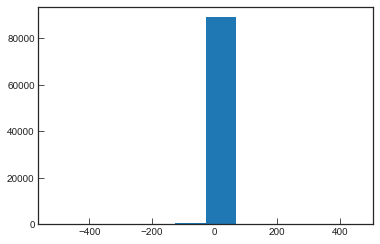

In [66]:
plt.hist(stlr_gaia.pmra.values)
m = np.isfinite(stlr_gaia.pmra.values)
print(len(stlr_gaia.pmra.values), len(stlr_gaia.pmra.values[m]))
print(stlr_gaia.pmra.values[0])

Calculate tangential velocities for these stars.

In [67]:
vel_ra = stlr_gaia.pmra.values / stlr_gaia.parallax.values
vel_dec = stlr_gaia.pmdec.values / stlr_gaia.parallax.values
TV = np.sqrt(vel_ra**2 + vel_dec**2)

Calculate vertical actions for all those stars.

In [97]:
os.remove("results/actions.txt")

jrs, lzs, jzs, z, vts = [np.zeros(len(stlr_gaia.kepid.values)) for i in range(5)]
with open("results/actions.txt", "a") as f:
    f.write("J_R,L_z,J_Z")
    for i, star in enumerate(stlr_gaia.kepid.values):
        RV = stlr_gaia.radial_velocity[i]*1
        if np.isnan(RV):
            RV = 0.
            
        # Calculate actions
        R_kpc, phi_rad, z_kpc, vR_kms, vT_kms, vz_kms, jR, lz, Jz = \
                action(stlr_gaia.ra_gaia.values[i], stlr_gaia.dec_gaia.values[i], 
                1./stlr_gaia.parallax.values[i], 
                stlr_gaia.pmra.values[i], 
                stlr_gaia.pmdec.values[i], RV)
           
        jrs[i] = jR
        lzs[i] = lz
        jzs[i] = Jz
        z[i] = z_kpc
        vts[i] = vT_kms
        if i % 100 == 0:
            print(i, "of", len(stlr_gaia.kepid.values))
            print(z[i])
        f.write("{},{},{}".format(jrs[i], lzs[i], jzs[i]))

0 of 89536
0.19543386548120723
100 of 89536
0.2647064711409845
200 of 89536
0.27225705044684445
300 of 89536
0.040858284335983014
400 of 89536
-0.1196821551928336
500 of 89536
0.13530497860294102
600 of 89536
0.35885879834517936
700 of 89536
0.13959796952965725
800 of 89536
-1.037779312239889
900 of 89536
0.3225397942992108
1000 of 89536
0.5469762963267298
1100 of 89536
0.5851776889680083
1200 of 89536
0.11891669145712931
1300 of 89536
0.1158940177893579
1400 of 89536
0.4311709727486351
1500 of 89536
0.3953081511694163
1600 of 89536
0.3019036721594685
1700 of 89536
0.4473316653688133
1800 of 89536
0.14534298426454673
1900 of 89536
0.22247811498040732
2000 of 89536
0.20307485873033684
2100 of 89536
0.4517602998287171
2200 of 89536
0.40097502325873413
2300 of 89536
0.2662056227607687
2400 of 89536
0.19472658994493194
2500 of 89536
0.424714249880813
2600 of 89536
0.6983350789477886
2700 of 89536
0.5943709935567125
2800 of 89536
0.3721775238194415
2900 of 89536
0.413374813500308
3000 of 89

In [69]:
stlr_gaia["J_R"] = jrs
stlr_gaia["L_z"] = lzs
stlr_gaia["J_z"] = jzs
stlr_gaia["Z"] = z
stlr_gaia["tangential_velocity"] = TV
print(TV)

[0. 0. 0. ... 0. 0. 0.]


(-0.001, 0.001)

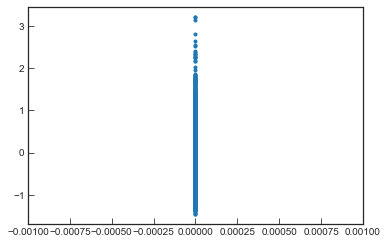

In [52]:
plt.plot(TV, np.log10(z), ".")

In [40]:
#plt.hist(stlr_gaia.J_z.values, 100)
print(stlr_gaia.J_z.values)

[ 2.32059556 14.10978163 11.00841909 ... 79.72770596 11.0246145
 14.53391141]


In [73]:
stlr_gaia.to_csv("stlr_gaia_actions.csv")

Now just the stars in Megan's catalogue?

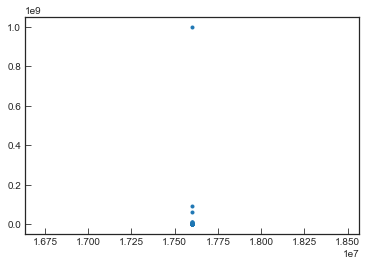

In [45]:
m = jrs > 1e7
plt.plot(jrs[m], jzs[m], ".")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':



Text(0,0.5,'log10 Jz')

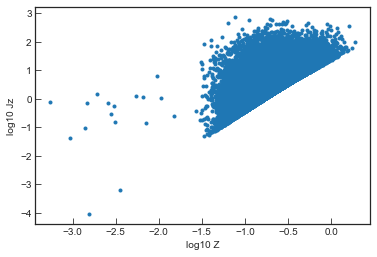

In [72]:
plt.plot(np.log10(z), np.log10(jzs), ".")
plt.xlabel("log10 Z")
plt.ylabel("log10 Jz")